In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
senti = pd.read_json("../graph_network/full_data_iv_29-04-24.json")
s = pd.read_json("../sentiment-analyser/saiv_28-04-24.json") 
pd.set_option('display.max_colwidth', None)

In [3]:
senti.columns

Index(['url', 'pagetitle', 'negative', 'neutral', 'positive', 'color', 'text',
       'linkedpages'],
      dtype='object')

In [2]:

senti[senti["url"]=="https://www.mobiliar.ch/versicherungen-und-vorsorge/services/schaden-melden"]

,url,pagetitle,negative,neutral,positive,color,text,linkedpages
30,https://www.mobiliar.ch/versicherungen-und-vorsorge/services/schaden-melden,Schaden melden,0.844019,0.061671,0.09431,#e62700,Schaden melden Ist Ihnen trotz aller Sorgfalt ein Schaden passiert? Dann helfen wir Ihnen rasch und unkompliziert. Die Mobiliar in Ihrer Nähe Möchten Sie Ihren Schaden persönlich besprechen? Die Generalagentur in Ihrer Nähe ist gern für Sie da. Agentur finden Kontakt aufnehmen,"[https://www.mobiliar.ch/, https://www.mobiliar.ch/versicherungen-und-vorsorge/services, https://secure.mobiliar.ch/mcs-osm-b2c/public/, https://secure.protekta.ch/mcs-osm-b2c/protekta/public/, https://osm.apps.mobiliar.ch/node/62/, https://www.mobiliar.ch/versicherungen-und-vorsorge/generalagenturen, https://www.mobiliar.ch/kontaktaufnahme]"


## Helper Functions

In [2]:
def save_as_json(pandas_dataframe, file_name):
    import datetime
    date_info = datetime.datetime.now().strftime("%d-%m-%y")
    pandas_dataframe.to_json(f"{file_name}_{date_info}.json", orient='records')


def get_mean_coefficients_per_cluster(df, cluster_col):
    coefficient_names = ["negative", "neutral", "positive"]
    for i in range(df[cluster_col].unique().shape[0]):
        count = df.loc[df[cluster_col]==i].shape[0]
        print(f"Cluster Nr. {i}; Total Pages in Cluster: {count}")
        for coeff in coefficient_names:
            print(f"avg {coeff}:", round(df.loc[df[cluster_col]==i, coeff].mean(), 5))
        print()


def append_mean_coefficients_per_cluster(df, cluster_col):
    coefficient_names = ["negative", "neutral", "positive"]
    mean_coeffs = df.groupby(cluster_col)[coefficient_names].mean().reset_index()
    mean_coeffs.rename(columns={name: f"avg_{cluster_col[:-3]}_{name[:3]}" for name in coefficient_names}, inplace=True)
    df = pd.merge(df, mean_coeffs, on=cluster_col, how='left')
    
    return df
        

def get_color(input_vector):
    import numpy as np
    red = np.array([1, 0, 0])
    yellow = np.array([1, 1, 0])
    green = np.array([0, 1, 0])
    rgb = input_vector[0] * red + input_vector[1] * yellow + input_vector[2] * green
    color = "#" + "".join(f"{int(x*255):02x}" for x in rgb)
    return color


def add_color_column_of_df_to_matrix(dataframe, cluster_column, new_col_names):
    dataframe[f"color_{cluster_column}"] = (
        dataframe[new_col_names]
        .apply(lambda row: np.array(row), axis=1)
        .apply(lambda row: get_color(row))
    )
    # result = pd.merge(matrix, dataframe[["url", "color"]], how="left", on=["url"])
    return dataframe

def get_cluster_average_color(df, cluster_column, columns_to_average):
    new_col_names=[]
    for col in columns_to_average:
        average_col_name = f"m_{col}"  # Erzeuge Namen für die neuen Durchschnittsspalten
        df[average_col_name] = df.groupby(cluster_column)[col].transform('mean')
        new_col_names.append(average_col_name)
    df = add_color_column_of_df_to_matrix(df, cluster_column, new_col_names)
    for average_col_name in new_col_names:
        df.drop(average_col_name, axis=1, inplace=True)
    return df

def get_mean_sentiment_coefficients_of_neighbours(pandas_dataframe):
    coefficient_names = ["negative", "neutral", "positive"]
    for coefficient in coefficient_names:
        results = []
        result_dataframe = pandas_dataframe
        all_urls = pandas_dataframe.url.tolist()
        for url in all_urls:
            idx = all_urls.index(url)
            linkedpages_per_url = pandas_dataframe.at[idx, "linkedpages"]
            mean_of_neighbours = pandas_dataframe.loc[pandas_dataframe["url"].isin(linkedpages_per_url), coefficient].mean()
            results.append(round(mean_of_neighbours, 5))
        pandas_dataframe.insert(loc=len(pandas_dataframe.columns), column=f"avg_{coefficient}_of_neighbours", value=results)
    return pandas_dataframe


def append_cluster_color(df, cluster_col):
    cluster_sizes = df[cluster_col].value_counts().sort_values(ascending=False)
    cmap = plt.get_cmap('turbo') #viridis
    num_of_clusters = len(cluster_sizes)
    colors = [cmap(i / num_of_clusters) for i in range(num_of_clusters)]
    color_mapping = {cluster_id: color for cluster_id, color in zip(cluster_sizes.index, colors)}
    df[f'color_{cluster_col}'] = df[cluster_col].apply(lambda x: color_mapping[x])


def get_cluster_plot(pandas_df, cluster_col):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    color_col = f"color_{cluster_col}"
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pandas_df['negative'], pandas_df['neutral'], pandas_df['positive'], c=pandas_df[color_col])
    ax.set_xlabel('Negative')
    ax.set_ylabel('Neutral')
    ax.set_zlabel('Positive')
    plt.show()

### Overview Plot

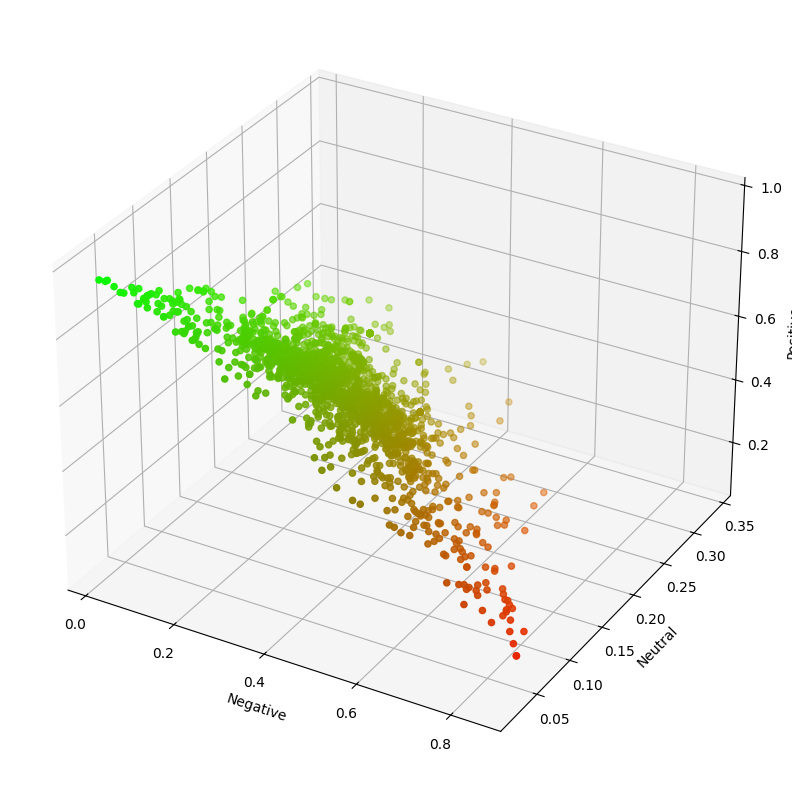

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111, projection='3d')

x = senti["negative"]
y = senti["neutral"]
z = senti["positive"]
color = senti["color"]
ax.scatter3D(x, y, z, c=color)
ax.set_xlabel('Negative')
ax.set_ylabel('Neutral')
ax.set_zlabel('Positive')
plt.show()

In [ ]:
# XY-Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y, c=color)
ax.set_xlabel('Negative')
ax.set_ylabel('Neutral')
plt.title('2D Plot - XY Plane')
plt.show()

# XZ-Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, z, c=color)
ax.set_xlabel('Negative')
ax.set_ylabel('Positive')
plt.title('2D Plot - XZ Plane')
plt.show()

# YZ-Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y, z, c=color)
ax.set_xlabel('Neutral')
ax.set_ylabel('Positive')
plt.title('2D Plot - YZ Plane')
plt.show()

## Word-Clouds

In [59]:
senti['word_count'] = senti['text'].apply(lambda x: len(str(x).split()))

In [45]:
def clean_url(url):
    if 'mobiliar.ch' in url:
        return url.replace('https://www.mobiliar.ch', '').lstrip('/').replace('/', ', ')
        # if "die-mobiliar" in url:
        #     return url.replace('die-mobiliar', '').lstrip('/').replace('/', ', ')
    return url.replace('/', ', ')

# Anwenden der Funktion auf die 'url'-Spalte und Erstellen einer neuen Spalte
senti['cleaned_url'] = senti['url'].apply(clean_url)

In [90]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [109]:
text = senti.drop_duplicates(subset=['text', "negative", "neutral", "positive"]).sort_values("positive", ascending=False)[:25]["text"].str.cat(sep=" ")

# text = senti.loc[senti["cluster"]==2]["text"].str.cat(sep=" ")
print ("There are {} words.".format(len(text)))

There are 22686 words.


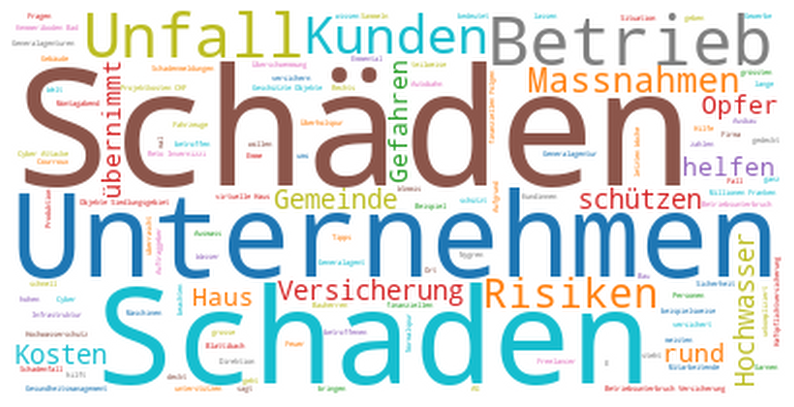

In [108]:
stop_words = []
with open("../sentiment-analyser/german_stopwords.txt", 'r', encoding='utf-8') as file:
    content = file.read()
    stop_words = [word.strip() for word in content.split(',')]

stopwords = set(STOPWORDS)
stopwords.update(stop_words + ["mobiliar", "z.B.", "jQuery", "getScript", "hasJquery", "function", "undefined", "letTimeout"])

wordcloud = WordCloud(stopwords=stopwords, background_color="white", colormap="tab10").generate(text)

plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='lanczos')
plt.axis("off")
plt.show()